In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data = pd.read_csv('./Crop_recommendationV2.csv')

X = data.drop('label', axis=1)
y = data['label']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

feature_names = preprocessor.get_feature_names_out()

In [5]:
feature_names

array(['num__N', 'num__P', 'num__K', 'num__temperature', 'num__humidity',
       'num__ph', 'num__rainfall', 'num__soil_moisture', 'num__soil_type',
       'num__sunlight_exposure', 'num__wind_speed',
       'num__co2_concentration', 'num__organic_matter',
       'num__irrigation_frequency', 'num__crop_density',
       'num__pest_pressure', 'num__fertilizer_usage', 'num__growth_stage',
       'num__urban_area_proximity', 'num__water_source_type',
       'num__frost_risk', 'num__water_usage_efficiency'], dtype=object)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_train_encoded = to_categorical(label_encoder.transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0650 - loss: 3.0728 - val_accuracy: 0.1562 - val_loss: 2.8880
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1613 - loss: 2.8112 - val_accuracy: 0.2756 - val_loss: 2.4471
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3034 - loss: 2.2955 - val_accuracy: 0.4631 - val_loss: 1.7938
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4715 - loss: 1.6991 - val_accuracy: 0.6761 - val_loss: 1.1654
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6341 - loss: 1.1933 - val_accuracy: 0.7756 - val_loss: 0.7955
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7049 - loss: 0.8523 - val_accuracy: 0.7812 - val_loss: 0.6270
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7543 - loss: 0.7105 - val_accuracy: 0.8835 - val_loss: 0.4663
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7907 - loss: 0.6305 - val_accuracy: 0.8892 - val_loss

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 22))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 22))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional

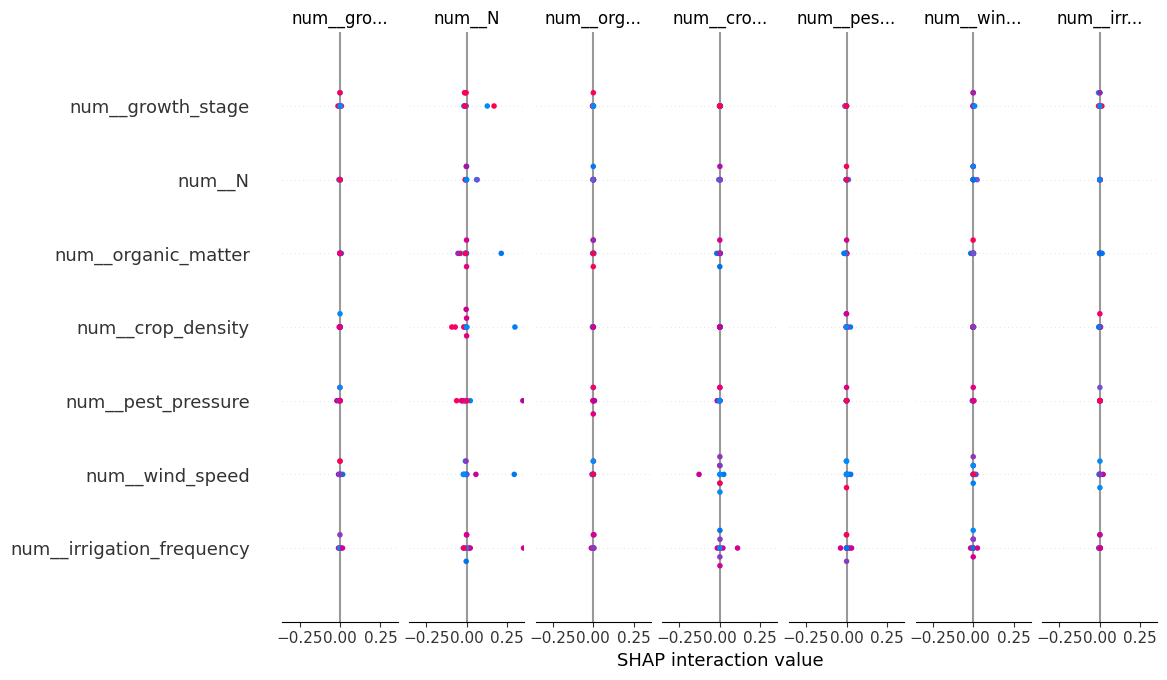

In [7]:
import shap

explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.summary_plot(shap_values, X_test[:10], feature_names=feature_names)

In [8]:
shap_values.shape

(10, 22, 22)